In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from collections import Counter
import re

In [30]:
# imports 
chemotaxis = pd.read_csv('../data/superfocus/long_term_migration_chemotaxis_level3_relabund.tsv', index_col=0)
chemotaxis.columns = [i[:10] for i in chemotaxis.columns]
metadata = pd.read_csv('../metadata/long_term_migration_metadata.csv')
chemotaxis.index = chemotaxis['Function_n']
chemotaxis = chemotaxis.drop(['Function_n'], axis=1)

# drop rows that we don't want to include 
chemotaxis = chemotaxis.drop('hypothetical protein', axis=0)

# fill in the zeros 
# Calculate the percentage of NaN values across each row
nan_percentage = chemotaxis.isna().mean(axis=1)

# Filter rows where more than half of the values are NaN
threshold = 0.5
chemotaxis = chemotaxis[nan_percentage < threshold]

In [31]:
start_fame = metadata[metadata['location'] == 'start']['FAME']
end_fame = metadata[metadata['location'] == 'end']['FAME']

In [32]:
tube_dict = dict(zip(metadata['FAME'], metadata['tube']))
location_dict = dict(zip(metadata['FAME'], metadata['location']))

end_df = chemotaxis[end_fame].stack().reset_index()
end_df['location'] = ['end' for e in range(len(end_df))]  
end_df['tube'] = [tube_dict.get(i) for i in end_df['level_1']]

start_df = chemotaxis[start_fame].stack().reset_index()
start_df['location'] = ['start' for e in range(len(start_df))] 
start_df['tube'] = [tube_dict.get(i) for i in start_df['level_1']]

chemotaxis_stacked = pd.concat([end_df, start_df])

# transform the data 
chemotaxis_stacked['log abundance'] = np.log(chemotaxis_stacked[0])

### plot the difference in proportion as well 

In [34]:
start_means = pd.DataFrame(start_df.groupby('Function_n')[0].mean())
end_means = pd.DataFrame(end_df.groupby('Function_n')[0].mean())

# difference in the mean proportion
mean_proportion = start_means - end_means 
mean_proportion = mean_proportion.sort_values(0)

### Compute the difference in mean proportion at the sample level

In [36]:
# could have the 95% confidence interval marked on this plot instead potentially 
start_end_merged =start_df.drop('location', axis=1).merge(end_df.drop('location', axis=1), how = 'outer', on = [ 'Function_n', 'tube' ],
                                                         suffixes = ['_start', '_end'],)
start_end_merged['diff'] = start_end_merged['0_end'] - start_end_merged['0_start']
start_end_merged['diff_abs'] = np.abs(start_end_merged['diff'])

# this line is incorrect - need to go back and adjust 
mean_diff = pd.DataFrame(start_end_merged.groupby('Function_n')['diff'].mean())
mean_diff['start_vs_end'] = [1 if i < 0 else 0 for i in mean_diff['diff']]
mean_diff_dict = dict(zip(mean_diff.index.to_list(), mean_diff['start_vs_end']))
start_end_merged['start_vs_end']  = [mean_diff_dict.get(i) for i in start_end_merged['Function_n'].to_list()]


In [37]:
start_functions = chemotaxis[start_fame]
end_functions = chemotaxis[end_fame]
p_values = [] 
sig = []

for i in range(len(chemotaxis)): 
    
    # this is equivalent to performing Welch's t test 
    s, p = stats.ttest_ind(start_functions.iloc[i], end_functions.iloc[i], equal_var = False)
    sig.append(s)
    p_values.append(p)

# assemble into a dataframe to investigate further 
ttest_df = pd.DataFrame.from_dict({"Function": chemotaxis.index, 's': sig, 'p': p_values})

In [38]:
sig_functions = ttest_df[ttest_df['p'] < 0.05]
chemotaxis_sig_functions = chemotaxis_stacked[chemotaxis_stacked['Function_n'].isin(sig_functions['Function'])]

In [94]:
ttest_df

,Function,s,p
26,Tripeptide binding,-6.582119,0.000032
17,MCP III,-4.223627,0.000805
20,MCP I,-4.321720,0.001219
27,RbsB,-3.602493,0.004455
19,MCP IV,-3.298039,0.005604
28,CheA,-3.295020,0.008085
10,Dipeptide binding,-2.928314,0.012789
4,CheR,2.694480,0.013952
18,MCP II,-2.703694,0.021274
11,FliG,2.216612,0.040082


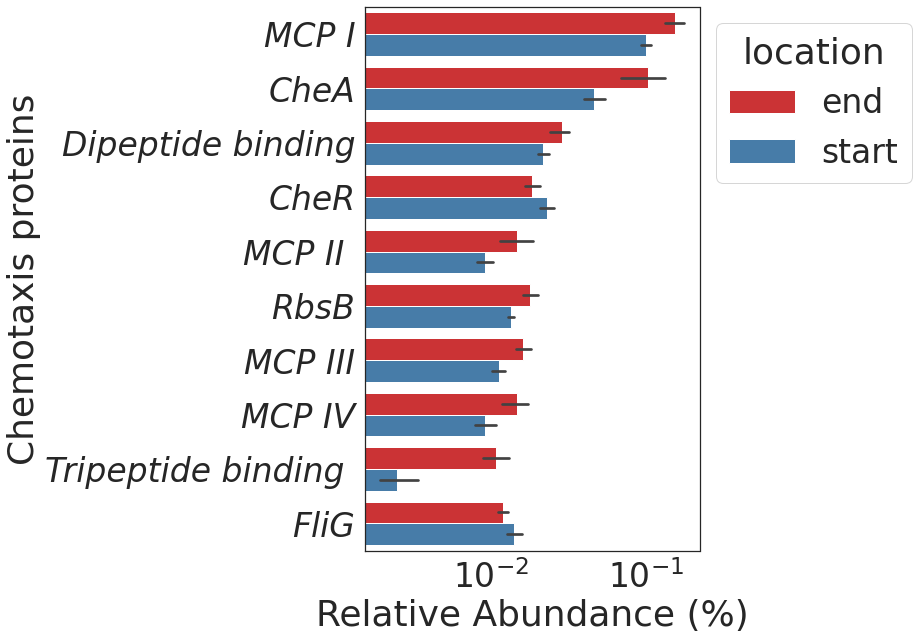

In [41]:
sns.set(rc={'figure.figsize':(6,10)}, font_scale=3, style = 'white')
# Custom colors for hue categories
palette = {'start': '#377eb8', 'end': '#e41a1c'}

ax = sns.barplot(data=chemotaxis_sig_functions.sort_values('log abundance', ascending = False), y = 'Function_n', hue = 'location', x = 0, palette=palette)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('Relative Abundance (%)')
plt.ylabel('Chemotaxis proteins')
plt.xscale('log')
# Set x tick labels to italic
ax.set_yticklabels(ax.get_yticklabels(), fontstyle='italic')
plt.savefig('../figures/long_term_migration_chemotaxis_barplot.png', bbox_inches='tight')

## Make Figure for the difference in subsystems

In [59]:
deseq_level3 = pd.read_csv('../output_files/long_term_migration_signficiant_changed_subsystems.csv', index_col= 0)

In [45]:
# what if we plot the abundance of the level 3 subsystems or their differences 
level3_subsystem = pd.read_csv('../data/superfocus/long_term_migration_level3_relabund.tsv', sep = '\t', index_col = 'Subsystem 3' )

In [46]:
level3_subsystem_abund = level3_subsystem*100/level3_subsystem.sum()
level3_subsystem_abund_stacked = pd.DataFrame(level3_subsystem_abund.stack()).reset_index() 

In [47]:
level3_subsystem_abund_stacked['sample'] = [re.split('_',i)[0] for i in level3_subsystem_abund_stacked['level_1']]
level3_subsystem_abund_stacked['location'] = [location_dict.get(i) for i in level3_subsystem_abund_stacked['sample']]

In [49]:
level3_subsystem_means = level3_subsystem_abund_stacked.drop([ 'level_1', 'sample'], axis=1).groupby(['Subsystem 3', 'location']).mean().unstack(level='location').reset_index()

In [50]:
level3_subsystem_abund_stacked['tube'] = [tube_dict.get(i) for i in level3_subsystem_abund_stacked['sample']]
level3_subsystem_abund_stacked_start = level3_subsystem_abund_stacked[level3_subsystem_abund_stacked['location'] == 'start']
level3_subsystem_abund_stacked_end = level3_subsystem_abund_stacked[level3_subsystem_abund_stacked['location'] == 'end']

# something wrong with this merge that is creating more lines 
level3_subsystem_abund_stacked_diff = level3_subsystem_abund_stacked_start.merge(level3_subsystem_abund_stacked_end, how = 'outer', on = ['Subsystem 3', 'tube'], suffixes = ('_start', '_end'))
level3_subsystem_abund_stacked_diff['diff'] = level3_subsystem_abund_stacked_diff['0_end'] - level3_subsystem_abund_stacked_diff['0_start'] 
level3_subsystem_abund_stacked_diff['diff_abs'] = np.abs(level3_subsystem_abund_stacked_diff['diff'])


In [64]:
plot_diff = level3_subsystem_abund_stacked_diff[level3_subsystem_abund_stacked_diff['Subsystem 3'].isin(deseq_level3.index.to_list())]

In [65]:
# compute the means for each category
sig_subsystems = list(set(plot_diff['Subsystem 3']))

sig_means = [] 
for s in sig_subsystems: 
    mean = plot_diff[plot_diff['Subsystem 3'] == s]['diff'].mean()
    sig_means.append(mean) 

sig_subsystems_means = pd.DataFrame({'Subsystem 3': sig_subsystems, 'Mean': sig_means})
sig_subsystems_means['Mean_abs'] = np.abs(sig_subsystems_means['Mean'])
sig_subsystems_means = sig_subsystems_means.sort_values('Mean_abs', ascending = False)


In [83]:
# color whether there was an overal increase or decrease 
plot_diff_mean = plot_diff.groupby('Subsystem 3').mean('diff')
plot_diff_mean['status'] = ['increase' if i > 0 else 'decrease' for i in plot_diff_mean['diff']]
plot_diff_status_dict = dict(zip(plot_diff_mean.index, plot_diff_mean['status'])) 
plot_diff_mean_dict = dict(zip(plot_diff_mean.index, plot_diff_mean['diff'])) 

In [68]:
# take names to update the figure 
names_dict = {'ABC transporter branched-chain amino acid (TC 3.A.1.4.1)': 'Polypeptide transport',
 'Bacterial Chemotaxis': 'Bacterial Chemotaxis',
 'Carnitine Metabolism in Microorganisms': 'Carnitine Metabolism', 
 'Colonization factor antigen I fimbriae': 'Fimbriae colonization factor' ,
 'Malonate decarboxylase': 'Malonate decarboxylase',
 'Two partner secretion pathway (TPS)': 'Two partner secretion pathway',
 'p-Aminobenzoyl-Glutamate Utilization': 'p-Aminobenzoyl-Glutamate Utilization',
 'CBSS-196164.1.peg.1690': 'Iron-sulfur cluster',
 'Coenzyme B12 biosynthesis': 'Coenzyme B12 biosynthesis',
 'Hydrogenases': 'Hydrogenases',
 'Pyrimidine utilization': 'Pyrimidine utilization',
 'Autoinducer 2 (AI-2) transport and processing (lsrACDBFGE operon)': 'Autoinducer transport',
 'Glycerol fermentation to 1,3-propanediol': 'Glycerol fermentation',
 'Mannose-sensitive hemagglutinin type 4 pilus' : 'Mannose-sensitive pilus',
 'Siderophore Yersiniabactin Biosynthesis' : 'Yersiniabactin Biosynthesis',
 'Transposase in enterics': 'Transposase in enterics',
 'Alkylphosphonate utilization': 'Alkylphosphonate utilization',
 'Methylcitrate cycle': 'Methylcitrate cycle',
 'Cinnamic Acid Degradation': 'Cinnamic Acid Degradation',
 'Propanediol utilization': 'Propanediol utilization'}

<ipython-input-88-2091683549e9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_diff_top10['nickname'] = [names_dict.get(i) for i in plot_diff_top10['Subsystem 3']]
<ipython-input-88-2091683549e9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_diff_top10['status'] = [plot_diff_status_dict.get(i) for i in plot_diff_top10['Subsystem 3']]


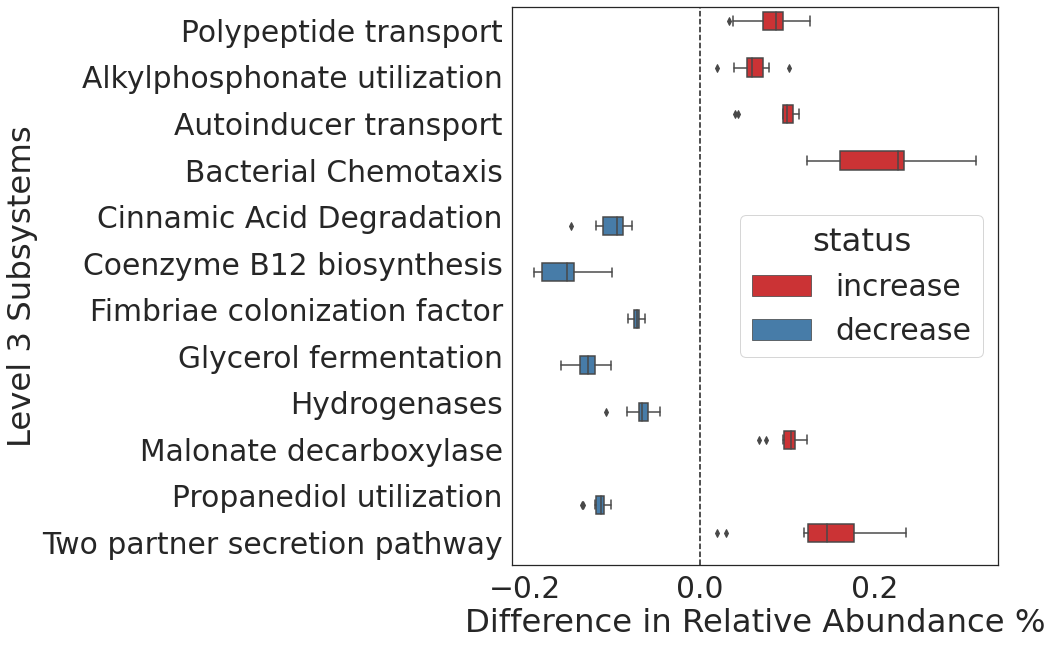

In [88]:
# Filter data
plot_diff_top10 = plot_diff[plot_diff['Subsystem 3'].isin(sig_subsystems_means.iloc[:12]['Subsystem 3'].tolist())]
plot_diff_top10['nickname'] = [names_dict.get(i) for i in plot_diff_top10['Subsystem 3']]
plot_diff_top10['status'] = [plot_diff_status_dict.get(i) for i in plot_diff_top10['Subsystem 3']]

# Define red and blue palette
palette = {'decrease': '#377eb8', 'increase': '#e41a1c'}

sns.set(rc={'figure.figsize': (8.7, 10.27)}, font_scale=2.7, style='white')
ax = sns.boxplot(data=plot_diff_top10, y='nickname', x='diff', hue='status', palette=palette)
ax.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Difference in Relative Abundance %')
plt.ylabel('Level 3 Subsystems')
plt.savefig('../figures/long_term_migration__level3subsystems_difference.png', bbox_inches='tight')
plt.show()